# Trophic model for gut
## Consumer-Resource model (CRM) with Trophic levels
The human gut microal community is complex because of 3 reason: (1) many microbial species (~570); (2) many metabolites involoved (~244); and (3) many microbe-metabolite interactions/links (>4400). Of all types of microbe-metabolite interactions/links, the cross-feeding makes the system more complicated to interpret. Previously, a literature-curated interspecies network of the human gut microbiota, called [NJS16](https://www.nature.com/articles/ncomms15393) is reported. This is an extensive data resource composed of ∼570 microbial species and 3 human cell types metabolically interacting through >4,400 small-molecule transport and macromolecule degradation events.

Here, we devoted to build a Consumer-Resource model (CRM) with trophic levels posted in the paper "[a evidence for a multi-level trophic organization of the human gut microbiome](https://www.biorxiv.org/content/10.1101/603365v1.full-text)". The model is devoted to study the complex microbe-metabolite network in human guts.

In concise, in the mode, a trophic level is considered as one round of carbon processing and is composed of two process: resource allocation to microbes and the following resource/byproduct generation by microbes. The simulation is stopped after several trophic levels because the residence time of resource in the human gut is assumed to be finite.

Previously, the code for the model is written in Matlab. Here a Python version of the model is proposed, providing further convenience for Machine Learning model to learn uptake rates and byproduct generation rates of all microbial species to different metabolites.

In [1]:
########### Self-customized setting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import sklearn
import math
from numba import jit, float64

#%% Plot Tong's default setting
SMALL_SIZE = 15
MEDIUM_SIZE = 15
BIGGER_SIZE = 15

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['axes.linewidth'] = 3

In [2]:
########### import the pickled file containing all processed data which are useful for simulations (the processing is
########### done in "Trophic_model_for_gut_data_processing.ipynb")
import pickle
pickle_in = open("Chia_network.pickle","rb")
net, i_selfish, i_intake, names = pickle.load(pickle_in)

pickle_in = open("Thai_data.pickle","rb")
thai_metagenome_ID, thai_metagenome, thai_metabolome_ID, thai_metabolome = pickle.load(pickle_in)

## Create maps of microbes and metabolites to their reduced matrix forms

In [3]:
#i_nonzero_microbes = net['microbes_ID'].unique()
#i_nonzero_microbes = np.sort(i_nonzero_microbes)
i_nonzero_microbes = thai_metagenome_ID.values.copy()
i_nonzero_metabolites = net['metabolites_ID'].unique()
i_nonzero_metabolites = np.sort(i_nonzero_metabolites)


df_metabolites = pd.DataFrame.from_dict({'oldID': i_nonzero_metabolites, 'newID':list(range(len(i_nonzero_metabolites)))})
df_metabolites.set_index('oldID', inplace=True)
df_microbes = pd.DataFrame.from_dict({'oldID': i_nonzero_microbes, 'newID':list(range(len(i_nonzero_microbes)))})
df_microbes.set_index('oldID', inplace=True)


outgoingNodes = df_metabolites.loc[net['metabolites_ID'].values].values.flatten()
ingoingNodesTemp = df_microbes.loc[net['microbes_ID'].values].values.flatten()
edge_types = net.iloc[~np.isnan(ingoingNodesTemp),2].values
outgoingNodes = outgoingNodes[~np.isnan(ingoingNodesTemp)]
ingoingNodes = ingoingNodesTemp[~np.isnan(ingoingNodesTemp)].astype(int)

net_reduced = pd.DataFrame.from_dict({'metabolites': outgoingNodes, 'microbes':ingoingNodes, 'edgeType':edge_types})
net = net_reduced.copy()

thai_metagenome_ID_reduced = df_microbes.loc[thai_metagenome_ID].values.flatten()
thai_metagenome_ID = thai_metagenome_ID_reduced[~np.isnan(thai_metagenome_ID_reduced)].astype(int)

thai_metabolome_ID_reduced = df_metabolites.loc[thai_metabolome_ID].values.flatten()
thai_metabolome_ID = thai_metabolome_ID_reduced[~np.isnan(thai_metabolome_ID_reduced)].astype(int)


i_selfish_reduced = df_microbes.loc[i_selfish].values.flatten()
i_selfish = i_selfish_reduced[~np.isnan(i_selfish_reduced)].astype(int)

i_intake_reduced = df_metabolites.loc[i_intake].values.flatten()
i_intake = i_intake_reduced[~np.isnan(i_intake_reduced)].astype(int)

/Users/tongwang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  from ipykernel import kernelapp as app
/Users/tongwang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


## Run the simulation with reduced matrix forms for one individual

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3.2986932508967106
            Iterations: 14
            Function evaluations: 310
            Gradient evaluations: 14
     fun: 3.2986932508967106
     jac: array([ 0.        , -0.00607041,  0.00249973,  0.00244379,  0.01342097,
        0.01750383,  0.01855433,  0.00281239,  0.00334352,  0.01648417,
       -0.00632995,  0.00306493,  0.02916449,  0.05973503, -0.00965661,
        0.0092881 ,  0.1019651 ,  0.00812569,  0.00533977,  0.02321699])
 message: 'Optimization terminated successfully.'
    nfev: 310
     nit: 14
    njev: 14
  status: 0
 success: True
       x: array([5.00000000e-02, 2.88444573e-03, 1.21632546e+00, 9.06181188e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.36143685e-02, 0.00000000e+00, 1.45227455e-01, 1.21038497e+00,
       2.98634689e-17, 3.27114524e-17, 8.90697495e-01, 5.52302836e-01,
       4.27068948e-18, 1.59140976e-02, 5.64292766

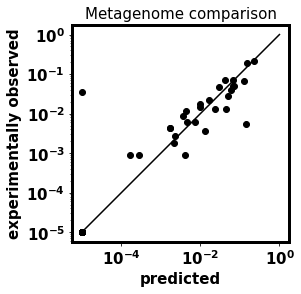

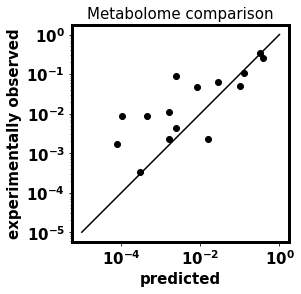

In [4]:
################################# Predict metabolome from individual's metagenome.
from numpy import array
from scipy.sparse import csr_matrix
import numpy.matlib
from scipy.optimize import minimize, rosen, rosen_der
from scipy.stats import pearsonr

MAX_ID_microbes = len(i_nonzero_microbes)  # MAX_ID_microbes is the maximum of ID labels for microbes.
MAX_ID_metabolites = len(i_nonzero_metabolites)  # MAX_ID_metabolites is the maximum of ID labels for metabolites.

def Ain_out(b_real, net):
    '''
    Ain_out is a function used to create sparse matrices made of metabolites and microbes 
    where metabolite consumption and production is considered. The matrices created are "m2b" and "b2m":
    (1) m2b is a matrix determines the nutrient splitting among microbes, and
    (2) b2m is a matrix determines the byproducts generation.
    Both matrices have rows representing bacterial species and columns representing metablolites.
    Two matrices are created based on (1) the metabolite consumption and production network which is 
    encode in "net" as a dataframe, and (2) the experimentally measured bacterial abundance "b_real".
    '''
    valid_index = np.where((net.iloc[:,2]==2) | (net.iloc[:,2]==5))[0]
    row = net.iloc[valid_index,0]
    col = net.iloc[valid_index,1]
    data = np.ones((len(valid_index),))
    m2b = csr_matrix( (data,(row,col)), shape=(MAX_ID_metabolites, MAX_ID_microbes)).toarray()#.todense()

    valid_index = np.where((net.iloc[:,2]==3) | (net.iloc[:,2]==5))[0]
    row = net.iloc[valid_index,0]
    col = net.iloc[valid_index,1]
    data = np.ones((len(valid_index),))
    b2m = csr_matrix( (data,(row,col)), shape=(MAX_ID_metabolites, MAX_ID_microbes)).toarray()#.todense()

    ########## Normalize the b2m by out_degree
    out_degree = b2m.sum(0).copy()
    out_degree[out_degree==0]=100
    b2m = (b2m / out_degree)

    ########## Normalize the m2b by proportion of microbial abundance in each individual
    b_real_repmat = numpy.matlib.repmat(b_real[np.newaxis,:], MAX_ID_metabolites, 1)
    m2b = m2b * b_real_repmat
    in_degree = m2b.sum(1)
    in_degree[in_degree==0]=100
    m2b = m2b / numpy.matlib.repmat(in_degree[:,np.newaxis], 1, MAX_ID_microbes)
    m2b = np.float32(m2b)
    b2m = np.float32(b2m)
    return [m2b, b2m]

def m2b_multiple_levels(f, m2b, b2m, numLevels_max):
    '''
    m2b_multiple_levels is a function used to generate matrices involving the calculation of metabolite 
    byproducts and microbial biomass after several trophic levels/layers. Those matrices are:
    (1) m2m_layer is a conversion matrix from the nutrient intake to the metabolite byproducts at a trophic
    level or layer.
    (2) m2m_total is a conversion matrix from the nutrient intake to a summation of metabolite byproducts at
    all trophic levels or layers.
    (3) m2b_total is a conversion matrix from the nutrient intake to a summation of all microbial/bacterial 
    biomass gain at all trophic levels or layers.
    Those matrices are computed based on (1) metabolite consumption matrix "m2b", (2) metabolite byproduct
    generation matrix "b2m", (3) byproduct/leakage fraction "f", and (4) number of trophic levels/layers in the 
    simulation "numLevels_max".
    '''
    m2m_layer = np.zeros((MAX_ID_metabolites, MAX_ID_metabolites, numLevels_max));  
    #m2b_total = np.zeros((MAX_ID_metabolites, MAX_ID_microbes));  
    m2b_total = np.zeros((MAX_ID_metabolites, MAX_ID_metabolites));  
    
    f_mul = numpy.matlib.repmat(f, 1, MAX_ID_metabolites)
    #s_step =  np.dot(b2m, m2b.T) # s_step is the conversion matrix of each trophic level/layer
    s_step =  np.dot(b2m, f_mul*m2b.T) # s_step is the conversion matrix of each trophic level/layer
    s_step_ii = np.eye(MAX_ID_metabolites, MAX_ID_metabolites);
    #f_mul = numpy.matlib.repmat(f[np.newaxis,:], MAX_ID, 1)#numpy.matlib.repmat(f, 1, MAX_ID)
    #f_mul = numpy.matlib.repmat(f, 1, MAX_ID_metabolites)
    
    for ii in range(numLevels_max):
        # m2b_total is a series made of s_step of each layer
        #m2b_total = m2b_total + f_mul**(ii) * s_step_ii
        #m2m_layer[:,:,ii] = f_mul**(ii) * s_step_ii
        m2b_total = m2b_total + s_step_ii
        m2m_layer[:,:,ii] = s_step_ii
        s_step_ii = np.dot(s_step_ii, s_step);  
    m2m_total = m2b_total;
    m2b_total = np.dot((1 - f_mul) * m2b.T, m2b_total) # m2b_total has an extra multiplication of m2b and (1-f).
    return [m2b_total, m2m_total, m2m_layer]

def pred_error(x, b_real, m2b_total, i_intake):
    '''
    pred_error is a function used to compute the logarithmic error between experimentally measured
    metagenome and predicted metagenome computed from the model for a certain nutrient intake. It relies on 
    (1) x: the nutrient intake, (2) i_intake: IDs of the nutrient intake, (3) m2b_total: a conversion matrix 
    from thenutrient intake to the total biomass, and (4) b_real: experimentally measured metagenome. The 
    first three is used to compute the metagenome predicted by the model "ba_pred" and compare it with the 
    experimentally measured metagenome "b_real".
    '''
    x_full = np.zeros((MAX_ID_metabolites,));
    x_full[i_intake] = x;
    
    ba_pred = np.dot(m2b_total, x_full)
    pred_error = (np.log10(ba_pred + 1e-6) - np.log10(b_real +1e-6)) / np.log10(b_real +1e-6);
    pred_error = np.sqrt(np.dot(pred_error, pred_error.T)) #np.sqrt(np.sum(pred_error**2))
    return pred_error

def calc_metabolome(x, m2m_layer, numLevels_max, i_intake):
    '''
    calc_metabolome is a function used to calculate the metabolome from the fitted nutrient intake from the
    model. It relies on (1) x: the nutrient intake, (2) i_intake: IDs of the nutrient intake, (3) m2m_layer: 
    a conversion matrix from the nutrient intake to the metabolite byproducts at a trophic level or layer, 
    and (4) numLevels_max: the number of trophic levels/layers in the model. The metabolome in the model is 
    assumed to be composed of two parts: (1) met_levels: all metabolites in the final trophic level/layer 
    (which is considered to be reaching the end of the gut because of the finite gut length and gut motility.),
    and (2) met_leftover_levels: all unusable metabolites from all previous trophic levels/layers. 
    '''
    i_unused = np.where(np.sum(m2b.T,0) == 0)[0]
    met_levels = np.zeros((MAX_ID_metabolites, numLevels_max));  
    met_leftover_levels = np.zeros((MAX_ID_metabolites, numLevels_max));
    
    x_full = np.zeros((MAX_ID_metabolites,));
    x_full[i_intake] = x;
    
    for ii in range(numLevels_max):
        met_levels[:,ii] = np.dot(m2m_layer[:,:,ii], x_full)
        if ii==0:
            met_leftover_levels[i_unused,ii] = x_full[i_unused]
        else:
            met_leftover_levels[i_unused,ii] = met_levels[i_unused,ii-1]
            
    return [met_levels, met_leftover_levels]

f_byproduct = 0.9
f = f_byproduct * np.ones((MAX_ID_microbes,1));
f[i_selfish] = 0.0;  # The byproduct/leakage fraction f for microbes that don't generate byproducts is set as 0.

numLevels_max = 4

######## Select an ID of a individual and pull out its experimentally measured metagenome:
pa = 3; 
b_real = np.zeros((MAX_ID_microbes,))
b_real[thai_metagenome_ID] = thai_metagenome.iloc[:,pa] / np.sum(thai_metagenome.iloc[:,pa])

######## Compute matrices involving the metabolite consumption and generation:
m2b, b2m = Ain_out(b_real, net)
m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(f, m2b, b2m, numLevels_max)
#m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(i_nonzero_microbes, i_nonzero_metabolites, f, m2b, b2m, numLevels_max)

######## Assign diet
x0 = np.ones((len(i_intake),)) / len(i_intake)

######## The model is converted into an optimization problem where the nutrient intake is constantly changed to
# minimize the logarithmic error between experimentally measured metagenome and predicted metagenome computed 
# from the model for a certain nutrient intake.
fun = lambda x: pred_error(x, b_real, m2b_total, i_intake)
bnds = ((0, 100), ) * len(x0)
res = minimize(fun, x0, method='SLSQP', bounds=bnds, options={'disp': True, 'maxiter': 1000}, tol=1e-3)
#res = minimize(fun, x0, method='Nelder-Mead', bounds=bnds, options={'disp': True})
#res = minimize(fun, x0, method='TNC', bounds=bnds, options={'disp': True, 'maxiter': 1000})
print(res)

######## As long as the optimized nutrient intake is found by using the above optimization solver, the
# optimized nutrient intake "res.x" is used to generate the predict metagenome and metabolome. They are
# visually and statistically compared to the experimentally measured metagenome and metabolome.
x_full = np.zeros((MAX_ID_metabolites,));
x_full[i_intake] = res.x;
ba_pred = np.dot(m2b_total, x_full)

#### Metagenome comparison
fig, ax = plt.subplots()
ax.loglog(ba_pred+1e-5, b_real+1e-5, 'ko')
ax.plot([1e-5, 1], [1e-5, 1],'k-')
ax.set_aspect('equal')
ax.set_xlabel('predicted')
ax.set_ylabel('experimentally observed')
ax.set_title('Metagenome comparison')

met_levels, met_leftover_levels = calc_metabolome(res.x, m2m_layer, numLevels_max, i_intake)
metabolome_measured = np.zeros((MAX_ID_metabolites,))
#metabolome_measured[thai_metabolome_ID.values] = thai_metabolome.iloc[:,pa]
metabolome_measured[thai_metabolome_ID] = thai_metabolome.iloc[:,pa]
metabolome_pred = met_levels[:, -1] + met_leftover_levels.sum(1) #np.dot(m2m_total, x_full)
#metabolome_pred = np.dot(m2m_total, x_full)
i_common = np.where(metabolome_measured * metabolome_pred > 1e-5)[0]
metabolome_pred_common = metabolome_pred[i_common] / np.sum(metabolome_pred[i_common])
metabolome_measured_common = metabolome_measured[i_common] / np.sum(metabolome_measured[i_common])

#### Metabolome comparison
fig, ax = plt.subplots()
ax.loglog(metabolome_pred_common+1e-5, metabolome_measured_common+1e-5, 'ko')
ax.plot([1e-5, 1], [1e-5, 1],'k-')
ax.set_aspect('equal')
ax.set_xlabel('predicted')
ax.set_ylabel('experimentally observed')
ax.set_title('Metabolome comparison')

print('-------------------------------------------------------------------------------------------------------------')
print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:')
print(pearsonr(ba_pred[b_real>0], b_real[b_real>0]))
print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:')
print(pearsonr(metabolome_pred_common, metabolome_measured_common))

In [5]:
len(metabolome_measured_common)

15

## Run the simulation with reduced matrix forms for all individuals

In [178]:
corr_list = np.zeros((41,2))
diet_list = np.zeros((41, 20))
for pa in range(41):
    print(pa)
    ######## Select an ID of a individual and pull out its experimentally measured metagenome:
    b_real = np.zeros((MAX_ID_microbes,))
    b_real[thai_metagenome_ID] = thai_metagenome.iloc[:,pa] / np.sum(thai_metagenome.iloc[:,pa])

    ######## Compute matrices involving the metabolite consumption and generation:
    m2b, b2m = Ain_out(b_real, net)
    #m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(f, m2b, b2m, numLevels_max)
    m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(f, m2b, b2m, numLevels_max)

    ######## Assign diet
    x0 = np.ones((len(i_intake),)) / len(i_intake)

    ######## The model is converted into an optimization problem where the nutrient intake is constantly changed to
    # minimize the logarithmic error between experimentally measured metagenome and predicted metagenome computed 
    # from the model for a certain nutrient intake.
    fun = lambda x: pred_error(x, b_real, m2b_total, i_intake)
    bnds = ((0, 100), ) * len(x0)
    res = minimize(fun, x0, method='SLSQP', bounds=bnds, options={'maxiter': 1000}, tol=1e-3)

    ######## As long as the optimized nutrient intake is found by using the above optimization solver, the
    # optimized nutrient intake "res.x" is used to generate the predict metagenome and metabolome. They are
    # visually and statistically compared to the experimentally measured metagenome and metabolome.
    x_full = np.zeros((MAX_ID_metabolites,));
    x_full[i_intake] = res.x;
    ba_pred = np.dot(m2b_total, x_full)

    met_levels, met_leftover_levels = calc_metabolome(res.x, m2m_layer, numLevels_max, i_intake)
    metabolome_measured = np.zeros((MAX_ID_metabolites,))
    metabolome_measured[thai_metabolome_ID] = thai_metabolome.iloc[:,pa]
    metabolome_pred = met_levels[:, -1] + met_leftover_levels.sum(1) #np.dot(m2m_total, x_full)
    i_common = np.where(metabolome_measured * metabolome_pred > 1e-5)[0]
    metabolome_pred_common = metabolome_pred[i_common] / np.sum(metabolome_pred[i_common])
    metabolome_measured_common = metabolome_measured[i_common] / np.sum(metabolome_measured[i_common])

    corr_list[pa, 0] = pearsonr(ba_pred[b_real>0], b_real[b_real>0])[0]
    #corr_list[pa, 1] = pearsonr(metabolome_pred_common, metabolome_measured_common)[0]
    corr_list[pa, 1] = pearsonr(np.log10(metabolome_pred_common+1e-5), np.log10(metabolome_measured_common+1e-5))[0]
    diet_list[pa, :] = res.x

    print('-------------------------------------------------------------------------------------------------------------')
    print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:')
    print(pearsonr(ba_pred[b_real>0], b_real[b_real>0]))
    print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:')
    print(pearsonr(metabolome_pred_common, metabolome_measured_common))

0
-------------------------------------------------------------------------------------------------------------
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:
(0.4264852667826321, 0.009492041976102554)
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:
(0.6105969010967452, 0.0071135444908271405)
1
-------------------------------------------------------------------------------------------------------------
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:
(0.9011443329682665, 1.1288354642116656e-11)
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:
(0.3331254965868357, 0.22501672112879326)
2
-------------------------------------------------------------------------------------------------------------
(Correlation coefficient, P-value) of the 

-------------------------------------------------------------------------------------------------------------
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:
(0.9026760902451338, 2.245791866442632e-14)
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:
(0.7035739189153014, 0.0011218371688830548)
23
-------------------------------------------------------------------------------------------------------------
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:
(0.8927271146910619, 1.2980825988661904e-12)
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:
(0.5517751217581244, 0.01759700355239609)
24
-------------------------------------------------------------------------------------------------------------
(Correlation coefficient, P-value) of the

In [179]:
np.mean(corr_list[:,1])


0.6108124558596347

## Monte Carlo over adding links (using the optimized diet)

In [ ]:
net_ori = net.copy()

In [195]:
import random
######## Select all microbes in the Thai data:
b_real = np.zeros((MAX_ID_microbes,))
b_real[thai_metagenome_ID] = 0.05

######## Compute matrices involving the metabolite consumption and generation:
m2b, b2m = Ain_out(b_real, net)

m2b_ori = (m2b[np.ix_(thai_metabolome_ID,thai_metagenome_ID)]!=0).astype(int).copy()
b2m_ori = (b2m[np.ix_(thai_metabolome_ID,thai_metagenome_ID)]!=0).astype(int).copy()
x_ori = np.concatenate([m2b_ori.flatten(), b2m_ori.flatten()])
net_ori = net.copy()

def pred_error_addingLinks(x, m2b_ori, b2m_ori, x_ori):
    '''
    pred_error_addingLinks is a function used to compute the logarithmic error between experimentally measured
    metagenome and predicted metagenome computed from the model for a certain nutrient intake. It relies on 
    (1) x: the nutrient intake, (2) i_intake: IDs of the nutrient intake, (3) m2b_total: a conversion matrix 
    from thenutrient intake to the total biomass, and (4) b_real: experimentally measured metagenome. The 
    first three is used to compute the metagenome predicted by the model "ba_pred" and compare it with the 
    experimentally measured metagenome "b_real".
    '''
    max_links = thai_metabolome_ID.shape[0]*thai_metagenome_ID.shape[0]
    
    ######## Convert x to net structure:
    thres = 0.1
    x = x - x_ori
    m2b_added = x[:max_links].reshape((thai_metabolome_ID.shape[0], thai_metagenome_ID.shape[0]))
    #a = thai_metabolome_ID.iloc[np.where(m2b_added >= thres)[0]]
    #b = thai_metagenome_ID.iloc[np.where(m2b_added >= thres)[1]]
    a = thai_metabolome_ID[np.where(m2b_added >= thres)[0]]
    b = thai_metagenome_ID[np.where(m2b_added >= thres)[1]]
    c = [2] * np.where(m2b_added >= thres)[1].shape[0]
    net_added_consumption = pd.DataFrame({net_ori.columns[0]:list(a), net_ori.columns[1]:list(b), net_ori.columns[2]:c})

    b2m_added = x[max_links:].reshape((thai_metabolome_ID.shape[0], thai_metagenome_ID.shape[0]))
    #a = thai_metabolome_ID.iloc[np.where(b2m_added >= thres)[0]]
    #b = thai_metagenome_ID.iloc[np.where(b2m_added >= thres)[1]]
    a = thai_metabolome_ID[np.where(b2m_added >= thres)[0]]
    b = thai_metagenome_ID[np.where(b2m_added >= thres)[1]]
    c = [3] * np.where(b2m_added >= thres)[1].shape[0]
    net_added_production = pd.DataFrame({net_ori.columns[0]:list(a), net_ori.columns[1]:list(b), net_ori.columns[2]:c})
    
    net = pd.concat([net_ori, net_added_consumption, net_added_production])
    
    f_byproduct = 0.9
    f = f_byproduct * np.ones((MAX_ID_microbes,1));
    f[i_selfish] = 0.0;  # The byproduct/leakage fraction f for microbes that don't generate byproducts is set as 0.

    numLevels_max = 4

    corr_list_aveDiet = np.zeros((41,2))
    log_list_aveDiet = np.zeros((41,2))
    for pa in range(41):
        #print(pa)
        ######## Select an ID of a individual and pull out its experimentally measured metagenome:
        b_real = np.zeros((MAX_ID_microbes,))
        b_real[thai_metagenome_ID] = thai_metagenome.iloc[:,pa] / np.sum(thai_metagenome.iloc[:,pa])

        ######## Compute matrices involving the metabolite consumption and generation:
        m2b, b2m = Ain_out(b_real, net)
        #m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(f, m2b, b2m, numLevels_max)
        m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(f, m2b, b2m, numLevels_max)

        ######## As long as the optimized nutrient intake is found by using the above optimization solver, the
        # optimized nutrient intake "res.x" is used to generate the predict metagenome and metabolome. They are
        # visually and statistically compared to the experimentally measured metagenome and metabolome.
        #x_full = np.zeros((MAX_ID_metabolites,));
        #x_full[i_intake] = average_diet.copy();
        #ba_pred = np.dot(m2b_total, x_full)
        
        
        ######## Assign diet
        x0 = np.ones((len(i_intake),)) / len(i_intake)

        ######## The model is converted into an optimization problem where the nutrient intake is constantly changed to
        # minimize the logarithmic error between experimentally measured metagenome and predicted metagenome computed 
        # from the model for a certain nutrient intake.
        fun2 = lambda y: pred_error(y, b_real, m2b_total, i_intake)
        bnds = ((0, 100), ) * len(x0)
        res = minimize(fun2, x0, method='SLSQP', bounds=bnds, options={'disp': False, 'maxiter': 1000}, tol=1e-3, callback=None)
        #res = minimize(fun, x0, method='Nelder-Mead', bounds=bnds, options={'disp': True})
        #res = minimize(fun, x0, method='TNC', bounds=bnds, options={'disp': True, 'maxiter': 1000})
        #print(res)

        ######## As long as the optimized nutrient intake is found by using the above optimization solver, the
        # optimized nutrient intake "res.x" is used to generate the predict metagenome and metabolome. They are
        # visually and statistically compared to the experimentally measured metagenome and metabolome.
        x_full = np.zeros((MAX_ID_metabolites,));
        x_full[i_intake] = res.x;
        ba_pred = np.dot(m2b_total, x_full)

        #met_levels, met_leftover_levels = calc_metabolome(average_diet.copy(), m2m_layer, numLevels_max, i_intake)
        met_levels, met_leftover_levels = calc_metabolome(res.x, m2m_layer, numLevels_max, i_intake)
        metabolome_measured = np.zeros((MAX_ID_metabolites,))
        metabolome_measured[thai_metabolome_ID] = thai_metabolome.iloc[:,pa]
        metabolome_pred = met_levels[:, -1] + met_leftover_levels.sum(1) #np.dot(m2m_total, x_full)
        i_common = np.where(metabolome_measured * metabolome_pred > 1e-5)[0]
        metabolome_pred_common = metabolome_pred[i_common] / np.sum(metabolome_pred[i_common])
        metabolome_measured_common = metabolome_measured[i_common] / np.sum(metabolome_measured[i_common])

        corr_list_aveDiet[pa, 0] = pearsonr(ba_pred[b_real>0], b_real[b_real>0])[0]
        corr_list_aveDiet[pa, 1] = pearsonr(metabolome_pred_common, metabolome_measured_common)[0]
        log_list_aveDiet[pa, 0] = np.mean(np.abs(np.log10(ba_pred[b_real>0]+1e-6) - np.log10(b_real[b_real>0]+1e-6)))
        log_list_aveDiet[pa, 1] = np.mean(np.abs(np.log10(metabolome_pred_common+1e-6) - np.log10(metabolome_measured_common+1e-6)))
        '''
        print('-------------------------------------------------------------------------------------------------------------')
        print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:')
        print(pearsonr(ba_pred[b_real>0], b_real[b_real>0]))
        print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:')
        print(pearsonr(metabolome_pred_common, metabolome_measured_common))
        '''  
        
    x_full = np.zeros((MAX_ID_metabolites,));
    x_full[i_intake] = res.x;
    
    ba_pred = np.dot(m2b_total, x_full)
    #pred_error1 = (np.log10(ba_pred + 1e-6) - np.log10(b_real +1e-6)) / np.log10(b_real +1e-6);
    #pred_error2 = (np.log10(metabolome_pred_common + 1e-6) - np.log10(metabolome_measured_common + 1e-6)) / np.log10(metabolome_measured_common + 1e-6);
    #pred_error1 = np.mean(corr_list_aveDiet[:,0])
    #pred_error2 = np.mean(corr_list_aveDiet[:,1])
    #pred_error3 = np.sum(np.abs(x))
    #hyper_reg = 0.01
    #pred_error = 1 - pred_error1 + 1 - pred_error2 + hyper_reg * pred_error3
    
    pred_error1 = np.mean(log_list_aveDiet[:,0])
    pred_error2 = np.mean(log_list_aveDiet[:,1])
    pred_error3 = np.sum(np.abs(x))
    hyper_reg = 0.001
    #pred_errorTotal = pred_error1 + pred_error2 + hyper_reg * pred_error3
    pred_errorTotal = pred_error2 + hyper_reg * pred_error3
    #print(pred_error, pred_error3)
    
    return pred_errorTotal

error_list = []
fun = lambda x: pred_error_addingLinks(x, m2b_ori, b2m_ori, x_ori)
max_links = thai_metabolome_ID.shape[0]*thai_metagenome_ID.shape[0]
x = x_ori.copy()
#nonChia = np.where(x_ori==0)[0]
error_before = fun(x)
print('The original error is', error_before)
error_list.append(error_before)
for i in range(3000):
    if i%50==0:
        print(i)
    #i_x = random.randint(0,max_links*2-1)
    i_x = random.choice(np.where(x==0)[0])
    x[i_x] = 1
    error_after = fun(x)
    if (error_before <= error_after):# (np.random.uniform(0,1,1)[0] >= np.exp(1000*(error_before - error_after))):  ## not accepted
        x[i_x] = 0
        #print('not accepted, error is', error_before)
    else:  ## accepted   
        error_before = error_after
        print('accepted, error is', error_before)
        error_list.append(error_before)
    #print(error_after / error_before)

The original error is 0.8981883586629497
0
accepted, error is 0.8910595938694404
accepted, error is 0.890394399925866
accepted, error is 0.8761402366709556
accepted, error is 0.8600919980827012
accepted, error is 0.8586126730957194
accepted, error is 0.8475744151460252
accepted, error is 0.8437507434180501
50
accepted, error is 0.83290869537415
accepted, error is 0.8258363876826799
accepted, error is 0.8187799543981182
accepted, error is 0.8174459143418074
accepted, error is 0.8174375143429307
100
accepted, error is 0.8007276415934007
accepted, error is 0.8002732898595398
accepted, error is 0.7980975475488844
accepted, error is 0.7859259407453357
150
accepted, error is 0.783301036193835
accepted, error is 0.7739869673862085
accepted, error is 0.7680904213131982
accepted, error is 0.7597942153160903
200
accepted, error is 0.7561567868399646
accepted, error is 0.7521144973151802
accepted, error is 0.7473104279431574
accepted, error is 0.7363183093209935
accepted, error is 0.7357678727025

In [196]:
len(error_list)
#error_list

104

In [197]:
######## Convert x to net structure:
thres = 0.1
x = x - x_ori
m2b_added = x[:max_links].reshape((thai_metabolome_ID.shape[0], thai_metagenome_ID.shape[0]))
#a = thai_metabolome_ID.iloc[np.where(m2b_added >= thres)[0]]
#b = thai_metagenome_ID.iloc[np.where(m2b_added >= thres)[1]]
a = thai_metabolome_ID[np.where(m2b_added >= thres)[0]]
b = thai_metagenome_ID[np.where(m2b_added >= thres)[1]]
c = [2] * np.where(m2b_added >= thres)[1].shape[0]
net_added_consumption = pd.DataFrame({net_ori.columns[0]:list(a), net_ori.columns[1]:list(b), net_ori.columns[2]:c})

b2m_added = x[max_links:].reshape((thai_metabolome_ID.shape[0], thai_metagenome_ID.shape[0]))
#a = thai_metabolome_ID.iloc[np.where(b2m_added >= thres)[0]]
#b = thai_metagenome_ID.iloc[np.where(b2m_added >= thres)[1]]
a = thai_metabolome_ID[np.where(b2m_added >= thres)[0]]
b = thai_metagenome_ID[np.where(b2m_added >= thres)[1]]
c = [3] * np.where(b2m_added >= thres)[1].shape[0]
net_added_production = pd.DataFrame({net_ori.columns[0]:list(a), net_ori.columns[1]:list(b), net_ori.columns[2]:c})

net_new = pd.concat([net_ori, net_added_consumption, net_added_production])

print(len(net_new), len(net_ori))


1140 1037


In [198]:
corr_list = np.zeros((41,2))
diet_list = np.zeros((41, 20))
log_list = np.zeros((41,2))
for pa in range(41):
    print(pa)
    ######## Select an ID of a individual and pull out its experimentally measured metagenome:
    b_real = np.zeros((MAX_ID_microbes,))
    b_real[thai_metagenome_ID] = thai_metagenome.iloc[:,pa] / np.sum(thai_metagenome.iloc[:,pa])

    ######## Compute matrices involving the metabolite consumption and generation:
    m2b, b2m = Ain_out(b_real, net_new)
    #m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(f, m2b, b2m, numLevels_max)
    m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(f, m2b, b2m, numLevels_max)

    ######## Assign diet
    x0 = np.ones((len(i_intake),)) / len(i_intake)

    ######## The model is converted into an optimization problem where the nutrient intake is constantly changed to
    # minimize the logarithmic error between experimentally measured metagenome and predicted metagenome computed 
    # from the model for a certain nutrient intake.
    fun = lambda x: pred_error(x, b_real, m2b_total, i_intake)
    bnds = ((0, 100), ) * len(x0)
    res = minimize(fun, x0, method='SLSQP', bounds=bnds, options={'maxiter': 1000}, tol=1e-3)

    ######## As long as the optimized nutrient intake is found by using the above optimization solver, the
    # optimized nutrient intake "res.x" is used to generate the predict metagenome and metabolome. They are
    # visually and statistically compared to the experimentally measured metagenome and metabolome.
    x_full = np.zeros((MAX_ID_metabolites,));
    x_full[i_intake] = res.x;
    ba_pred = np.dot(m2b_total, x_full)

    met_levels, met_leftover_levels = calc_metabolome(res.x, m2m_layer, numLevels_max, i_intake)
    metabolome_measured = np.zeros((MAX_ID_metabolites,))
    metabolome_measured[thai_metabolome_ID] = thai_metabolome.iloc[:,pa]
    metabolome_pred = met_levels[:, -1] + met_leftover_levels.sum(1) #np.dot(m2m_total, x_full)
    i_common = np.where(metabolome_measured * metabolome_pred > 1e-5)[0]
    metabolome_pred_common = metabolome_pred[i_common] / np.sum(metabolome_pred[i_common])
    metabolome_measured_common = metabolome_measured[i_common] / np.sum(metabolome_measured[i_common])

    corr_list[pa, 0] = pearsonr(ba_pred[b_real>0], b_real[b_real>0])[0]
    #corr_list[pa, 1] = pearsonr(metabolome_pred_common, metabolome_measured_common)[0]
    corr_list[pa, 1] = pearsonr(np.log10(metabolome_pred_common+1e-5), np.log10(metabolome_measured_common+1e-5))[0]
    log_list[pa, 0] = np.mean(np.abs(np.log10(ba_pred[b_real>0]+1e-6) - np.log10(b_real[b_real>0]+1e-6)))
    log_list[pa, 1] = np.mean(np.abs(np.log10(metabolome_pred_common+1e-6) - np.log10(metabolome_measured_common+1e-6)))
    diet_list[pa, :] = res.x

    print('-------------------------------------------------------------------------------------------------------------')
    print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:')
    print(pearsonr(ba_pred[b_real>0], b_real[b_real>0]))
    print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:')
    print(pearsonr(metabolome_pred_common, metabolome_measured_common))

0
-------------------------------------------------------------------------------------------------------------
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:
(0.3591279122378146, 0.031471439241589155)
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:
(0.30450801507331626, 0.06305175267959388)
1
-------------------------------------------------------------------------------------------------------------
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:
(0.9498957948600637, 1.1314928411624576e-15)
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:
(0.16515233534383644, 0.35836996444599467)
2
-------------------------------------------------------------------------------------------------------------
(Correlation coefficient, P-value) of the 

-------------------------------------------------------------------------------------------------------------
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:
(0.8124665819478151, 8.100344657596274e-07)
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:
(0.2180404091592175, 0.17084097158984118)
27
-------------------------------------------------------------------------------------------------------------
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:
(0.5540249446589757, 0.000822512806807442)
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:
(0.7718754342379925, 5.496067948543038e-09)
28
-------------------------------------------------------------------------------------------------------------
(Correlation coefficient, P-value) of the c

In [199]:
print(np.mean(corr_list[:,1]))
print(np.mean(log_list[:,1]))


0.6321461530098081
0.5742279037522043


In [200]:
NUMADDED = len(net_new) - len(net_ori)
print(NUMADDED)

103


In [201]:
df_added_metabolites = names.loc[df_metabolites.reset_index().set_index('newID').loc[net_new.iloc[-NUMADDED:,0]].values.flatten()]
df_added_metabolites.reset_index(inplace=True)
df_added_metabolites.columns = ['metabolite ID', 'metabolite names'] 

df_added_microbes = names.loc[df_microbes.reset_index().set_index('newID').loc[net_new.iloc[-NUMADDED:,1]].values.flatten()]
df_added_microbes.reset_index(inplace=True)
df_added_microbes.columns = ['microbes ID', 'microbes names'] 

df_added_edgeTypes = net_new.iloc[-NUMADDED:,2]
df_added_edgeTypes = pd.DataFrame(df_added_edgeTypes)
df_added_edgeTypes.index = range(NUMADDED)

df_added_errorReduced = -np.diff(error_list)
df_added_errorReduced = pd.DataFrame(df_added_errorReduced)
df_added_errorReduced.index = range(NUMADDED)
df_added_errorReduced.columns = ['error reduced'] 

df_added_tables = pd.concat([df_added_metabolites, df_added_microbes, df_added_edgeTypes,  df_added_errorReduced], axis=1, sort=False)
df_added_tables.sort_values(by = 'error reduced', ascending=False)



,metabolite ID,metabolite names,microbes ID,microbes names,edgeType,error reduced
38,2011,4-Aminobutyrate (GABA),135,Bacteroides uniformis,3,0.025728
12,2134,"L-Glutamine (D-Glutamine, Glutamine)",137,Bacteroides xylanisolvens,2,0.016710
3,2038,Butyrate,953,Roseburia inulinivorans,2,0.016048
2,2038,Butyrate,131,Bacteroides plebeius,2,0.014254
15,2148,"L-Proline (Proline, D-Proline)",124,Bacteroides eggerthii,2,0.012172
5,2081,Deoxycholic acid,123,Bacteroides dorei,2,0.011038
23,2217,Succinate,338,Coprococcus comes,2,0.010992
7,2122,Isovalerate (3-Methylbutanoic acid),55,Alistipes shahii,2,0.010842
17,2153,L-Threonine (Threonine),131,Bacteroides plebeius,2,0.009314
19,2160,Malonate,814,Parabacteroides merdae,2,0.008296


Text(0.5, 0, 'number of links added')

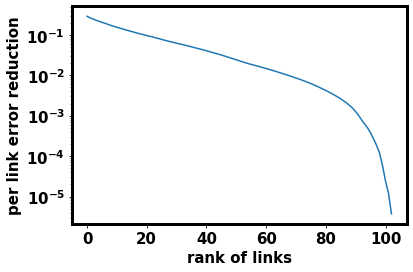

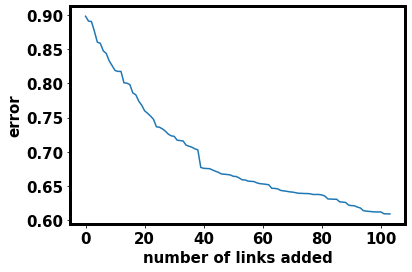

In [212]:
plt.figure()
plt.plot(np.cumsum(np.sort(df_added_tables['error reduced'].values))[::-1])
plt.yscale('log')
plt.ylabel('per link error reduction')
plt.xlabel('rank of links')

plt.figure()
plt.plot(error_list)
plt.ylabel('error')
plt.xlabel('number of links added')

In [204]:
df_MAMBO = pd.read_csv("mambo_curated.txt", sep = '\t')
df_MAMBO.head()

,microbe,metabolite,edge_type,microbe_Chia_name,microbe_ID,metabolite_Chia_name,metabolite_ID
0,"Bacteroides plebeius M12, DSM 17135","(S)-propane-1,2-diol",5,Bacteroides plebeius,131,"1,2-propanediol (Propene diol, Propylene glyco...",2004
1,"Bacteroides plebeius M12, DSM 17135",acetate,5,Bacteroides plebeius,131,Acetate,2014
2,"Bacteroides plebeius M12, DSM 17135",Adenosine,5,Bacteroides plebeius,131,Adenosine,2018
3,"Bacteroides plebeius M12, DSM 17135",Adenosylcobalamin,5,Bacteroides plebeius,131,"Adenosylcobalamin (Vitamin B12, Cobamide coenz...",2019
4,"Bacteroides plebeius M12, DSM 17135",L-arabinose,5,Bacteroides plebeius,131,"D-Arabinose (L-Arabinose, Arabinose, L-Arabino...",2060


In [205]:
chia_microbes_in_Thai = df_microbes.reset_index().set_index('newID').loc[thai_metagenome_ID].values.flatten()
chia_metabolites_in_Thai = df_metabolites.reset_index().set_index('newID').loc[thai_metabolome_ID].values.flatten()
#chia_microbes_in_Thai
#chia_microbes_in_Thai

df_MAMBO_filtered = df_MAMBO[df_MAMBO['microbe_ID'].apply(lambda x: x in chia_microbes_in_Thai)]
df_MAMBO_filtered = df_MAMBO_filtered[df_MAMBO_filtered['metabolite_ID'].apply(lambda x: x in chia_metabolites_in_Thai)]
print(len(df_MAMBO_filtered), x.shape[0])
print(len(df_MAMBO_filtered) / x.shape[0])

2162 11664
0.18535665294924555


In [206]:
k = 0
l = 0
for i in range(NUMADDED):
    if (np.sum((df_MAMBO['microbe_ID'] == df_added_tables['microbes ID'].iloc[i])) >=1 and 
       np.sum((df_MAMBO['metabolite_ID'] == df_added_tables['metabolite ID'].iloc[i]))>=1):
        l += 1
    if np.sum((df_MAMBO['microbe_ID'] == df_added_tables['microbes ID'].iloc[i]) & 
       (df_MAMBO['metabolite_ID'] == df_added_tables['metabolite ID'].iloc[i]))>=1:
        k += 1
print(l)
print(k)

76
44


3.868775411142167e-09

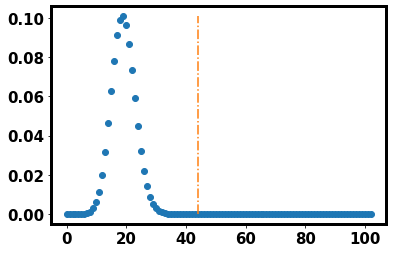

In [213]:
from scipy.stats import bernoulli, binom
xx = range(NUMADDED)
p = len(df_MAMBO_filtered) / x.shape[0]
#prob = bernoulli.cdf(xx, p)
probCum = binom.cdf(xx, NUMADDED, p)
prob = binom.pmf(xx, NUMADDED, p)
plt.plot(xx, prob, 'o')
plt.plot([k, k], [0, np.max(prob)], '-.')
1 - probCum[k]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2.6259721822119966
            Iterations: 9
            Function evaluations: 204
            Gradient evaluations: 9
     fun: 2.6259721822119966
     jac: array([ 0.00000000e+00,  4.26459312e-03,  1.23884887e-01,  4.06563282e-04,
        4.77891296e-01,  2.13326514e-02,  4.77891296e-01,  2.77922899e-01,
       -9.78895426e-02,  5.91114163e-03,  4.55306590e-01,  1.26545429e-01,
        1.07567757e-01,  5.59255481e-03,  3.32587957e-03,  1.22976661e-01,
        4.67244297e-01,  3.81114155e-01,  7.48643279e-03,  6.84148073e-03])
 message: 'Optimization terminated successfully.'
    nfev: 204
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([5.00000000e-02, 1.22964499e+00, 1.95823587e-13, 5.30153886e-02,
       1.97124694e-13, 7.30368251e-01, 1.89723757e-13, 1.55728676e-13,
       0.00000000e+00, 1.19617622e+00, 1.85047313e-13, 1.98309264e-13,
       1.82848855e-13, 1.19477075e+00

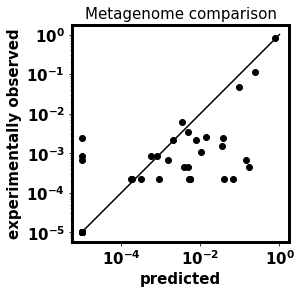

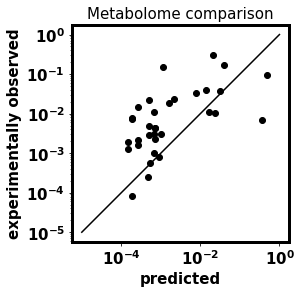

In [210]:
################################# Predict metabolome from individual's metagenome.

f_byproduct = 0.9
f = f_byproduct * np.ones((MAX_ID_microbes,1));
f[i_selfish] = 0.0;  # The byproduct/leakage fraction f for microbes that don't generate byproducts is set as 0.

numLevels_max = 4

######## Select an ID of a individual and pull out its experimentally measured metagenome:
pa = 1; 
b_real = np.zeros((MAX_ID_microbes,))
b_real[thai_metagenome_ID] = thai_metagenome.iloc[:,pa] / np.sum(thai_metagenome.iloc[:,pa])

######## Compute matrices involving the metabolite consumption and generation:
m2b, b2m = Ain_out(b_real, net_new)
m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(f, m2b, b2m, numLevels_max)
#m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(i_nonzero_microbes, i_nonzero_metabolites, f, m2b, b2m, numLevels_max)

######## Assign diet
x0 = np.ones((len(i_intake),)) / len(i_intake)

######## The model is converted into an optimization problem where the nutrient intake is constantly changed to
# minimize the logarithmic error between experimentally measured metagenome and predicted metagenome computed 
# from the model for a certain nutrient intake.
fun = lambda x: pred_error(x, b_real, m2b_total, i_intake)
bnds = ((0, 100), ) * len(x0)
res = minimize(fun, x0, method='SLSQP', bounds=bnds, options={'disp': True, 'maxiter': 1000}, tol=1e-3)
#res = minimize(fun, x0, method='Nelder-Mead', bounds=bnds, options={'disp': True})
#res = minimize(fun, x0, method='TNC', bounds=bnds, options={'disp': True, 'maxiter': 1000})
print(res)

######## As long as the optimized nutrient intake is found by using the above optimization solver, the
# optimized nutrient intake "res.x" is used to generate the predict metagenome and metabolome. They are
# visually and statistically compared to the experimentally measured metagenome and metabolome.
x_full = np.zeros((MAX_ID_metabolites,));
x_full[i_intake] = res.x;
ba_pred = np.dot(m2b_total, x_full)

#### Metagenome comparison
fig, ax = plt.subplots()
ax.loglog(ba_pred+1e-5, b_real+1e-5, 'ko')
ax.plot([1e-5, 1], [1e-5, 1],'k-')
ax.set_aspect('equal')
ax.set_xlabel('predicted')
ax.set_ylabel('experimentally observed')
ax.set_title('Metagenome comparison')

met_levels, met_leftover_levels = calc_metabolome(res.x, m2m_layer, numLevels_max, i_intake)
metabolome_measured = np.zeros((MAX_ID_metabolites,))
#metabolome_measured[thai_metabolome_ID.values] = thai_metabolome.iloc[:,pa]
metabolome_measured[thai_metabolome_ID] = thai_metabolome.iloc[:,pa]
metabolome_pred = met_levels[:, -1] + met_leftover_levels.sum(1) #np.dot(m2m_total, x_full)
#metabolome_pred = np.dot(m2m_total, x_full)
i_common = np.where(metabolome_measured * metabolome_pred > 1e-5)[0]
metabolome_pred_common = metabolome_pred[i_common] / np.sum(metabolome_pred[i_common])
metabolome_measured_common = metabolome_measured[i_common] / np.sum(metabolome_measured[i_common])

#### Metabolome comparison
fig, ax = plt.subplots()
ax.loglog(metabolome_pred_common+1e-5, metabolome_measured_common+1e-5, 'ko')
ax.plot([1e-5, 1], [1e-5, 1],'k-')
ax.set_aspect('equal')
ax.set_xlabel('predicted')
ax.set_ylabel('experimentally observed')
ax.set_title('Metabolome comparison')

print('-------------------------------------------------------------------------------------------------------------')
print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:')
print(pearsonr(ba_pred[b_real>0], b_real[b_real>0]))
print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:')
print(pearsonr(metabolome_pred_common, metabolome_measured_common))

In [211]:
from scipy.stats import pearsonr, spearmanr
print(pearsonr(metabolome_pred_common, metabolome_measured_common))
print(spearmanr(metabolome_pred_common, metabolome_measured_common))
print(pearsonr(np.log10(metabolome_pred_common+1e-5), np.log10(metabolome_measured_common+1e-5)))

(0.16515233534383644, 0.35836996444599467)
SpearmanrResult(correlation=0.6367903339818396, pvalue=6.768421527804663e-05)
(0.6077239873632551, 0.00017610255821343742)


In [21]:
#i_x
max_links*2












11664

## Add a prior distribution for picking links

In [ ]:
max_links = thai_metabolome_ID.shape[0]*thai_metagenome_ID.shape[0]
    
######## Convert x to net structure:
thres = 0.1
x = x - x_ori
m2b_added = x[:max_links].reshape((thai_metabolome_ID.shape[0], thai_metagenome_ID.shape[0]))


numpy.random.choice(numpy.arange(0, max_links*2), p=[0.1, 0.05, 0.05, 0.2, 0.4, 0.2])